Transpilers transform circuits written in circuits on a machine into a usable form for backends that only allow certain transformations or bases of transformations. 

The goal is to be able to easily write new circuit transformations (known as **transpiler passes**) and combine then with other existing passes. Which passes are chained together and in what order affects the outcome. This pipeline is determined by a **pass manager** which schedules the passes and allows passes to communicate with each other by providing a shared space. Transpilers thus allow for research into aggressive quantum circuit optimization. 

In [1]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile 
from qiskit.transpiler import PassManager

## Pass Manager Object

Let's you specify the set of passes you want 

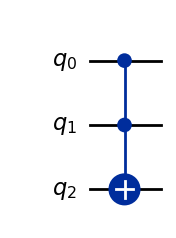

In [4]:
circ = QuantumCircuit(3)

circ.ccx(0, 1, 2)
circ.draw('mpl')

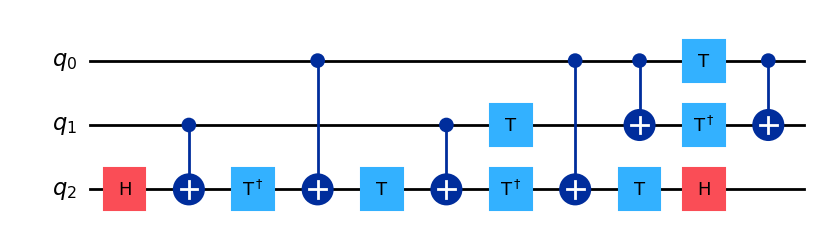

In [8]:
from qiskit.transpiler.passes import Unroll3qOrMore

pass_ = Unroll3qOrMore(['u1', 'u2', 'u3', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(circ)
new_circ.draw('mpl')

In [9]:
from qiskit.transpiler import passes

[pass_ for pass_ in dir(passes) if pass_[0].isupper()]

['ALAPSchedule',
 'ALAPScheduleAnalysis',
 'AQCSynthesisPlugin',
 'ASAPSchedule',
 'ASAPScheduleAnalysis',
 'AlignMeasures',
 'ApplyLayout',
 'BarrierBeforeFinalMeasurements',
 'BasicSwap',
 'BasisTranslator',
 'CSPLayout',
 'CXCancellation',
 'CheckGateDirection',
 'CheckMap',
 'Collect1qRuns',
 'Collect2qBlocks',
 'CollectCliffords',
 'CollectLinearFunctions',
 'CollectMultiQBlocks',
 'CommutationAnalysis',
 'CommutativeCancellation',
 'CommutativeInverseCancellation',
 'Commuting2qGateRouter',
 'ConsolidateBlocks',
 'ConstrainedReschedule',
 'ContainsInstruction',
 'ConvertConditionsToIfOps',
 'CountOps',
 'CountOpsLongestPath',
 'DAGFixedPoint',
 'DAGLongestPath',
 'Decompose',
 'DenseLayout',
 'Depth',
 'DynamicalDecoupling',
 'EchoRZXWeylDecomposition',
 'EnlargeWithAncilla',
 'Error',
 'FilterOpNodes',
 'FixedPoint',
 'FullAncillaAllocation',
 'GateDirection',
 'GatesInBasis',
 'HLSConfig',
 'HighLevelSynthesis',
 'HoareOptimizer',
 'InstructionDurationCheck',
 'InverseCancellat

Different Variants of the Same Pass

There can be passes that do the same job, but in different ways. The `TrivialLayout` `DenseLayout`, and `NoiseAdaptiveLayout` all choose a layout (binding virtual qubits to physical ones), but use different algorithms and objectives. Similarly, the `BasicSwap`, `LookaheadSwap`, and `StochasticSwap` all insert swaps to make the circuit compatible with a coupling map. The modularity of the transpiler allows plug-and-play replacements for each pass. 

Below I show the swapper passes being applied to the same circuit, to transform it to match a linear chain topology. You can see differences in performance, where `StochasticSwap` is clearly the best. This is not always the case though. 

In [11]:
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler.passes import BasicSwap, LookaheadSwap, StochasticSwap


circuit = QuantumCircuit(7)

circuit.h(3)
circuit.cx(0, 6)
circuit.cx(6, 0)
circuit.cx(0, 1)
circuit.cx(3, 1)
circuit.cx(3, 0)


coupling = [
    [0,1], 
    [1,2],
    [2,3],
    [3,4],
    [4,5], 
    [5,6]
]

coupling_map = CouplingMap(couplinglist = coupling)

bs = BasicSwap(coupling_map=coupling_map)
pass_manager = PassManager(bs)
basic_circ = pass_manager.run(circuit)

ls = LookaheadSwap(coupling_map = coupling_map)
pass_manager = PassManager(ls)
lookahead_circ = pass_manager.run(circuit)

ss = StochasticSwap(coupling_map = coupling_map)
pass_manager = PassManager(ss)
stochastic_circ = pass_manager.run(circuit)

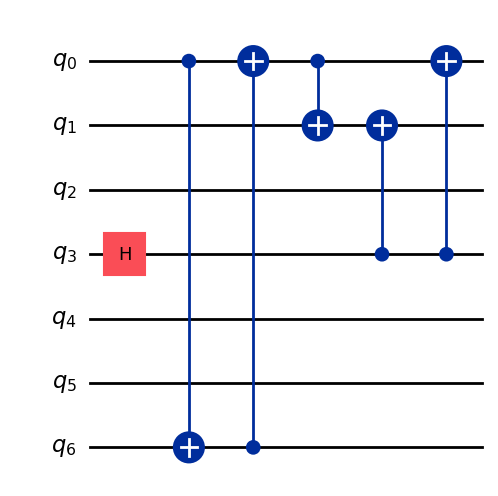

In [12]:
circuit.draw('mpl')

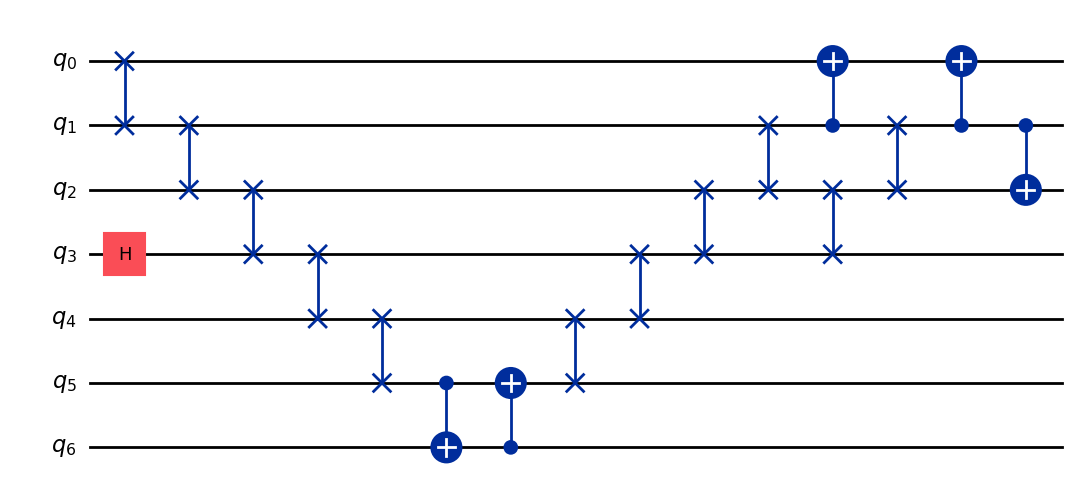

In [13]:
basic_circ.draw('mpl')

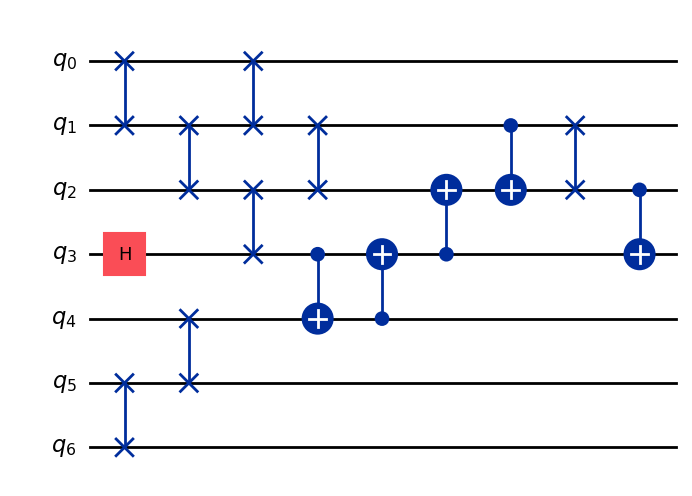

In [14]:
lookahead_circ.draw('mpl')

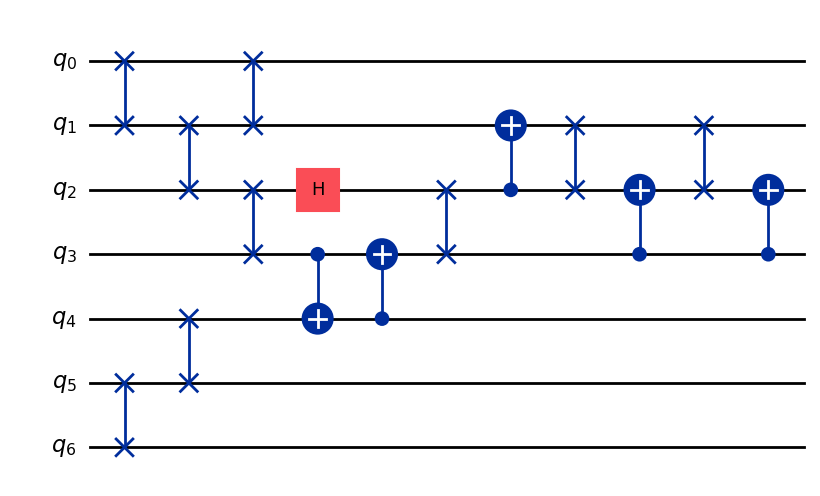

In [15]:
stochastic_circ.draw('mpl')

#### Preset Pass Managers

Qiskit has different pre-defined pms, with various levels of optimization achieved from a different pipeline of passes. 

- `optimization_level` = 0: just maps the circuit to the backend, no optimization
- `optimization_level` = 1: maps the circuit, collapses adjacent gates 
- `optimization_level` = 2: noise-adaptive layout and gate-cancellation procedure based on gate commutation relationships 
- `optimization_level` = 3: in addition does resynthesis of two-qubit blocks of gates in the circuit

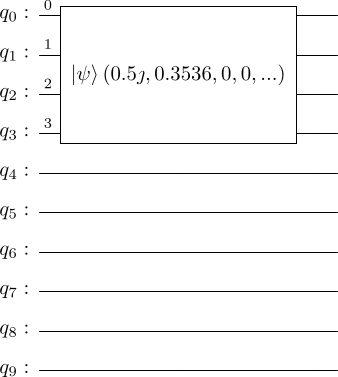

In [25]:
from math import sqrt
from qiskit.providers.fake_provider import Fake20QV1

backend = Fake20QV1()

qc = QuantumCircuit(10) 

random_state = [ 
    1 / 2 * 1j, 
    1 / sqrt(8),
    0,
    0,
    0,
    0,
    0,
    0, 
    1 / sqrt(8), 
    1 / sqrt(8) * 1j, 
    0,
    0,
    0,
    0,
    1 / 2, 
    1 / sqrt(8)
]

qc.initialize(random_state, range(4))
qc.draw('latex')

Now we map this to the Fake Backend, with different optimization levels

In [33]:
optimized_0 = transpile(qc, backend = backend, seed_transpiler=11, optimization_level=0)
print('gates = ', optimized_0.count_ops())
print('depth = ', optimized_0.depth())

optimized_1 = transpile(qc, backend = backend, seed_transpiler=11, optimization_level=1)
print('gates = ', optimized_1.count_ops())
print('depth = ', optimized_1.depth())

optimized_2 = transpile(qc, backend = backend, seed_transpiler=11, optimization_level=2)
print('gates = ', optimized_2.count_ops())
print('depth = ', optimized_2.depth())

optimized_3 = transpile(qc, backend = backend, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

gates =  OrderedDict({'cx': 58, 'u3': 15, 'u1': 15, 'reset': 4})
depth =  81
gates =  OrderedDict({'cx': 28, 'u3': 15, 'u1': 6, 'reset': 4})
depth =  47
gates =  OrderedDict({'cx': 26, 'u3': 15, 'u1': 6, 'reset': 4})
depth =  45
gates =  OrderedDict({'cx': 24, 'u3': 18, 'u1': 5, 'reset': 4, 'u2': 1})
depth =  44


/Users/devaldeliwala/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/devaldeliwala/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


## The DAG

In qiskit, circuits are represented internally using a Directed Acyclic Graph (DAG). The advantage of this representation over a pure list of gates is that the flow of information between operators is explicit, making it easier for passes to make transformation decisinos without changing the semantics of the circuit. 

In [34]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit

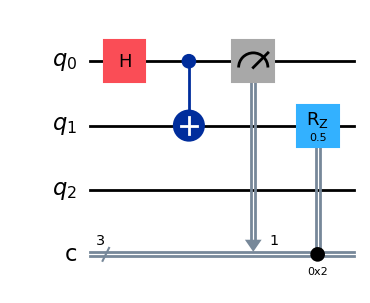

In [49]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')

circ = QuantumCircuit(q, c)
circ.h(q[0])
circ.cx(q[0], q[1])
circ.measure(q[0], c[1])
circ.rz(0.5, q[1]).c_if(c, 2)
circ.draw('mpl')

In the DAG, there are three different kinds of graph nodes: qubit/clbit input nodes (green), operation nodes (blue), and output nodes (red). Each edge indicates data flow (or dependency) between two nodes. 

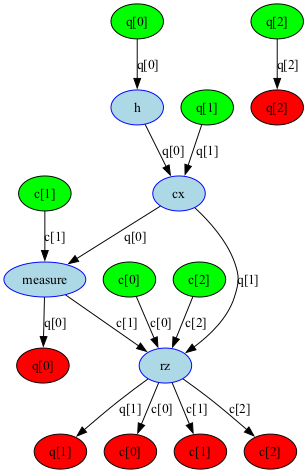

In [50]:
from qiskit.converters import circuit_to_dag 
from qiskit.visualization import dag_drawer

dag = circuit_to_dag(circ)
dag_drawer(dag)

Thus, writing a transpiler pass means using Qiskit's DAGCircuit API to analyze or transform the circuit. Let's see some examples of this. 

**a. Get all op nodes in the DAG**

In [51]:
dag.op_nodes()

[DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0),), cargs=()),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)), cargs=()),
 DAGOpNode(op=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0),), cargs=(Clbit(ClassicalRegister(3, 'c'), 1),)),
 DAGOpNode(op=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.5]), qargs=(Qubit(QuantumRegister(3, 'q'), 1),), cargs=())]

In [52]:
node = dag.op_nodes()[3] # example node

print('node name: ', node.name)
print('node.op: ', node.op)
print('node qargs: ', node.qargs)
print('node cargs: ', node.cargs)
print('node condition: ', node.op.condition)

node name:  rz
node.op:  Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.5])
node qargs:  (Qubit(QuantumRegister(3, 'q'), 1),)
node cargs:  ()
node condition:  (ClassicalRegister(3, 'c'), 2)


**b. Add an operation to the back**

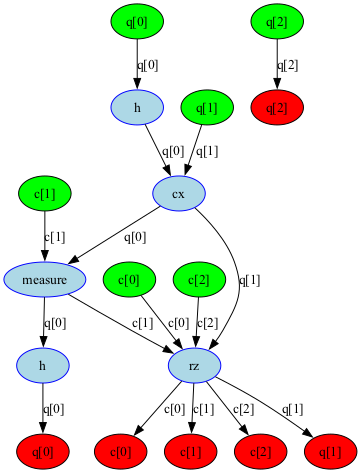

In [53]:
from qiskit.circuit.library import HGate

dag.apply_operation_back(HGate(), qargs = [q[0]])

dag_drawer(dag)

**c. Add an operation to the front:** 

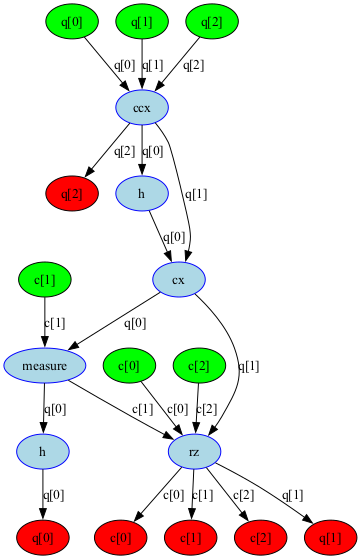

In [54]:
from qiskit.circuit.library import CCXGate

dag.apply_operation_front(CCXGate(), qargs = [q[0], q[1], q[2]], cargs = [])
dag_drawer(dag)

**d. Substitute a node with a subcircuit:** 

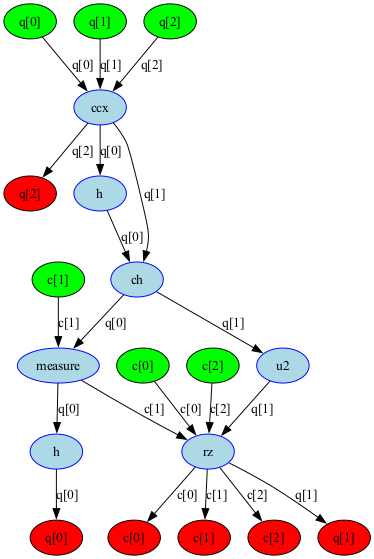

In [55]:
from qiskit.circuit.library import CHGate, U2Gate, CXGate 

mini_dag = DAGCircuit() 

p = QuantumRegister(2, 'p')
mini_dag.add_qreg(p)
mini_dag.apply_operation_back(CHGate(), qargs = [p[1], p[0]])
mini_dag.apply_operation_back(U2Gate(0.1, 0.2), qargs = [p[1]])

# substitute the cx node with the above mini-dag

cx_node = dag.op_nodes(op = CXGate).pop()
dag.substitute_node_with_dag(node = cx_node, input_dag = mini_dag, wires = [p[0], p[1]])
dag_drawer(dag)

Finally after all transformations are complete, we convert back to a regular `QuantumCircuit` object. This is what a transpiler does! Converts a circuit to DAG, operates on the DAG form, and outputs a transformed circuit. 

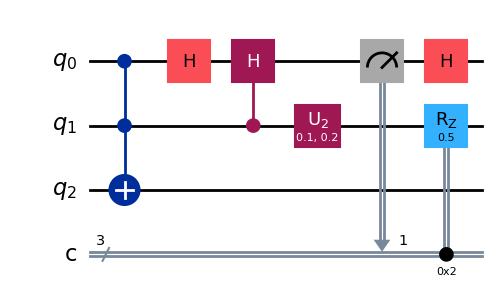

In [56]:
from qiskit.converters import dag_to_circuit 
circuit = dag_to_circuit(dag)
circuit.draw(output = 'mpl')

#### Implementing a BasicMapper Pass

Now that we are familiar with DAG, let's use it to write a transpiler pass. Here we implement a basic pass for mapping an arbitrary circuit to a device with limited qubit connecitvity. We call this the BasicMapper. 

When writing a transpiler pass we first decide whether the class derives from a `TransformationPass` or `AnalysisPass`. Transformation passes modify the circuit, while analysis passes only collect information about a circuit (to be used by other passes). Then the `run(dag)` method is implemented, which does the main task. Finally the pass is registered inside the `qiskit.transpiler.passes` module. 


This pass function is as follows: it traverses the DAG layer-by-layer (each layer is a group of operations acting on independent qubits, so in theory all operations in a layer can be done independently). For each operation, if it does not already meet the coupling map constraints, the pass identifies a swap path and inserts swaps to bring the two qubits close to each other. 

In [58]:
from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate

In [59]:
from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate


class BasicSwap(TransformationPass):
    """Maps (with minimum effort) a DAGCircuit onto a `coupling_map` adding swap gates."""

    def __init__(self,
                 coupling_map,
                 initial_layout=None):
        """Maps a DAGCircuit onto a `coupling_map` using swap gates.
        
        Args:
            coupling_map (CouplingMap): Directed graph represented a coupling map.
            initial_layout (Layout): initial layout of qubits in mapping
        """
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout

    def run(self, dag):
        """Runs the BasicSwap pass on `dag`.
        
        Args:
            dag (DAGCircuit): DAG to map.

        Returns:
            DAGCircuit: A mapped DAG.

        Raises:
            TranspilerError: if the coupling map or the layout are not
            compatible with the DAG.
        """
        new_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)
        

        if self.initial_layout is None:
            if self.property_set["layout"]:
                self.initial_layout = self.property_set["layout"]
            else:
                self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())

        if len(dag.qubits) != len(self.initial_layout):
            raise TranspilerError('The layout does not match the amount of qubits in the DAG')

        if len(self.coupling_map.physical_qubits) != len(self.initial_layout):
            raise TranspilerError(
                "Mappers require to have the layout to be the same size as the coupling map")
            
        canonical_register = dag.qregs['q']
        trivial_layout = Layout.generate_trivial_layout(canonical_register)
        current_layout = trivial_layout.copy()

        for layer in dag.serial_layers():
            subdag = layer['graph']

            for gate in subdag.two_qubit_ops():
                physical_q0 = current_layout[gate.qargs[0]]
                physical_q1 = current_layout[gate.qargs[1]]
                if self.coupling_map.distance(physical_q0, physical_q1) != 1:
                    # Insert a new layer with the SWAP(s).
                    swap_layer = DAGCircuit()
                    swap_layer.add_qreg(canonical_register)

                    path = self.coupling_map.shortest_undirected_path(physical_q0, physical_q1)
                    for swap in range(len(path) - 2):
                        connected_wire_1 = path[swap]
                        connected_wire_2 = path[swap + 1]

                        qubit_1 = current_layout[connected_wire_1]
                        qubit_2 = current_layout[connected_wire_2]

                        # create the swap operation
                        swap_layer.apply_operation_back(SwapGate(),
                                                        qargs=[qubit_1, qubit_2],
                                                        cargs=[])

                    # layer insertion
                    order = current_layout.reorder_bits(new_dag.qubits)
                    new_dag.compose(swap_layer, qubits=order)

                    # update current_layout
                    for swap in range(len(path) - 2):
                        current_layout.swap(path[swap], path[swap + 1])

            order = current_layout.reorder_bits(new_dag.qubits)
            new_dag.compose(subdag, qubits=order)

        return new_dag

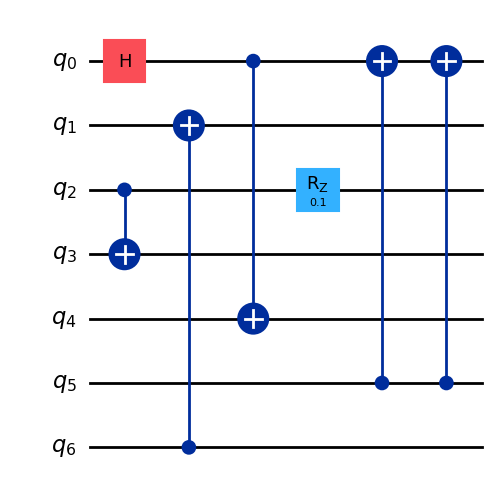

In [61]:
q = QuantumRegister(7, 'q')
in_circ = QuantumCircuit(q)

in_circ.h(q[0])
in_circ.cx(q[0], q[4])
in_circ.cx(q[2], q[3])
in_circ.cx(q[6], q[1])
in_circ.cx(q[5], q[0])
in_circ.rz(0.1, q[2])
in_circ.cx(q[5], q[0])

in_circ.draw('mpl')

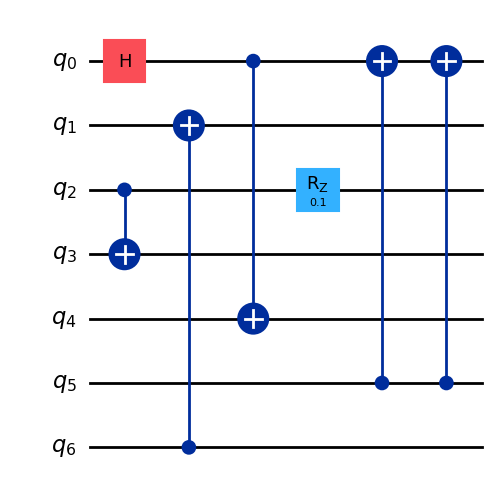

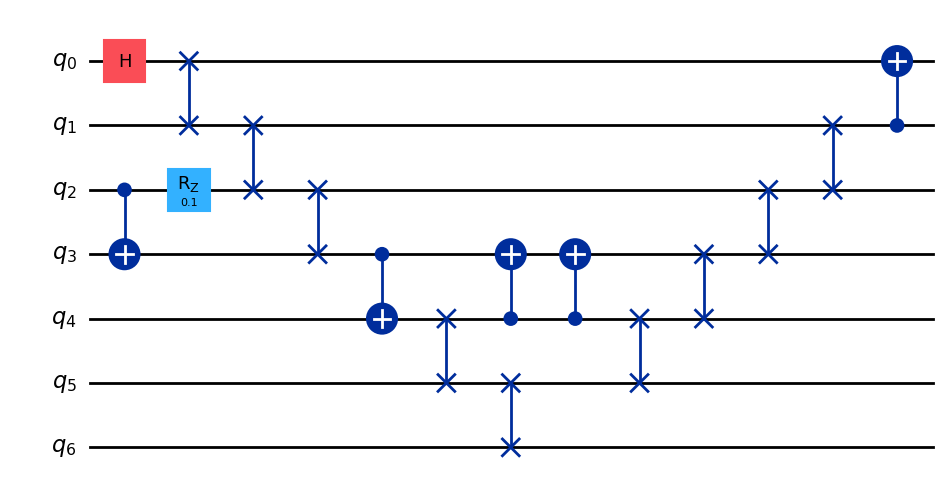

In [66]:
pm = PassManager()
coupling = [
    [0, 1], 
    [1, 2], 
    [2, 3], 
    [3, 4], 
    [4, 5], 
    [5, 6]
]

coupling_map = CouplingMap(couplinglist= coupling)

pm.append([BasicSwap(coupling_map)])
out_circ = pm.run(in_circ)

display(in_circ.draw('mpl'))
display(out_circ.draw('mpl'))


Note that this pass only inserts the swaps necessary to make every two-qubit interaction conform to the device coupling map. It does not, for example, care about the direction of interactions, or the native gate set supported by the device. This is a design philosophy of Qiskit's transpiler: every pass performs a small, well-defined action, and the aggressive circuit optimization is achieved by the pass manager through combining multiple passes.